# CNN + MaxPool
Excluding long sequences complicated the tracking of genes.
Also, it had a bias of affecting canonical transcripts more.
Now, keep the long sequences but truncate them.

Fixed bug in antilog computation.

Observe extreme overfitting.

In [12]:
from datetime import datetime
print(datetime.now())

2023-03-21 15:20:40.658572


In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [14]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [15]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [18]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [19]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 15:20:41.655876
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4997, 4)           1028      
                                                                 
 conv1d_8 (Conv1D)           (None, 4990, 128)         4224      
                                                                 
 conv1d_9 (Conv1D)           (None, 4983, 128)         131200    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1244, 128)        0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 1237, 64)          65600     
                                                                 
 conv1d_11 (Conv1D)          (None, 1230, 64)          32832     
                           

## Training

In [20]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [21]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 15:20:41.904942
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 15:20:51.534765

Training # 1 1
2023-03-21 15:20:51.544565
2023-03-21 15:20:51.544642
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 15:20:52.810872


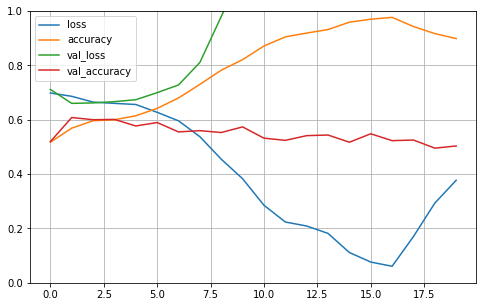


2023-03-21 15:23:16.475253

Testing # 1 1
2023-03-21 15:23:16.475380
2023-03-21 15:23:16.475421
PREDICT
2023-03-21 15:23:16.717821
Test 1:0 458:412 52.64%
Predict 1:0 374:496 42.99%
Test sizes (870, 4997) (870,)
Range of scores: 1.317124e-17 to 1.0
Score threshold 0.5
Confusion matrix
 [[238 174]
 [258 200]]
Normalized matrix
 [[0.27356322 0.2       ]
 [0.29655172 0.22988506]]


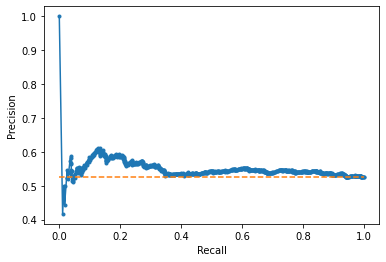

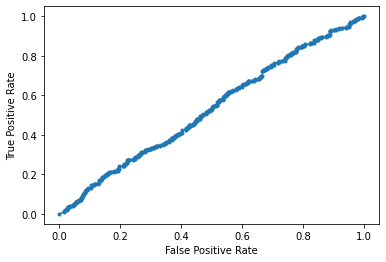

Accuracy: 50.34% Precision: 53.48% Recall: 43.67%
F1: 48.08% MCC: 0.0145
AUPRC: 54.95% AUROC: 53.03%
 accuracy [50.3448275862069]
 precision [53.475935828877006]
 recall [43.66812227074236]
 F1 [48.07692307692308]
 MCC [0.014474070166775418]
 AUPRC [54.951472093311516]
 AUROC [53.02709119430196]
2023-03-21 15:23:18.351721

Training # 1 2
2023-03-21 15:23:18.352720
2023-03-21 15:23:18.352776
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 15:23:19.645966


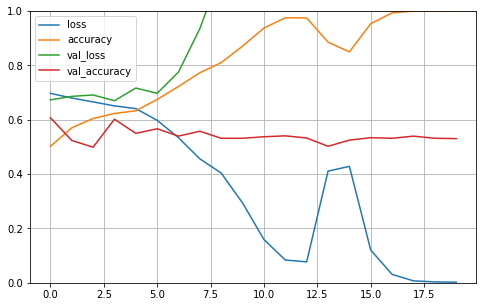


2023-03-21 15:25:25.840803

Testing # 1 2
2023-03-21 15:25:25.840909
2023-03-21 15:25:25.840954
PREDICT
2023-03-21 15:25:26.080212
Test 1:0 442:442 50.00%
Predict 1:0 461:423 52.15%
Test sizes (884, 4997) (884,)
Range of scores: 5.74919e-20 to 1.0
Score threshold 0.5
Confusion matrix
 [[225 217]
 [198 244]]
Normalized matrix
 [[0.25452489 0.24547511]
 [0.2239819  0.2760181 ]]


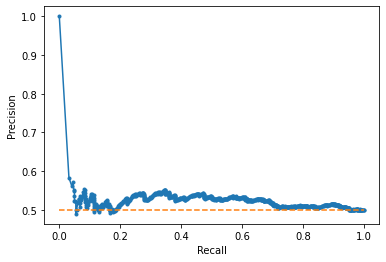

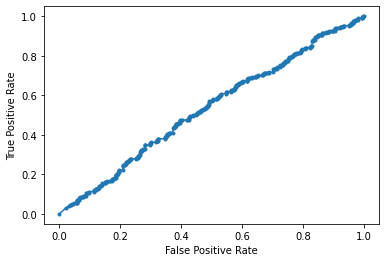

Accuracy: 53.05% Precision: 52.93% Recall: 55.20%
F1: 54.04% MCC: 0.0611
AUPRC: 53.11% AUROC: 53.55%
 accuracy [53.05429864253394]
 precision [52.92841648590022]
 recall [55.203619909502265]
 F1 [54.042081949058684]
 MCC [0.06114248951877465]
 AUPRC [53.1109002681289]
 AUROC [53.55029585798816]
2023-03-21 15:25:27.678527

Training # 1 3
2023-03-21 15:25:27.678749
2023-03-21 15:25:27.678800
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 15:25:30.091257


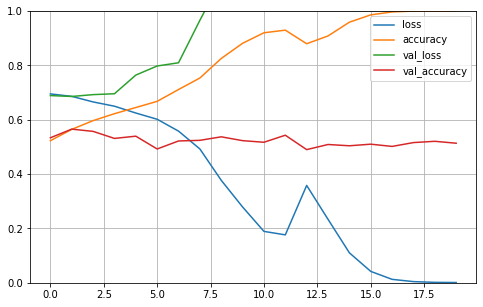


2023-03-21 15:27:36.353368

Testing # 1 3
2023-03-21 15:27:36.353480
2023-03-21 15:27:36.353520
PREDICT
2023-03-21 15:27:36.579958
Test 1:0 442:407 52.06%
Predict 1:0 433:416 51.00%
Test sizes (849, 4997) (849,)
Range of scores: 1.2198019e-15 to 1.0
Score threshold 0.5
Confusion matrix
 [[205 202]
 [211 231]]
Normalized matrix
 [[0.24146054 0.23792697]
 [0.24852768 0.27208481]]


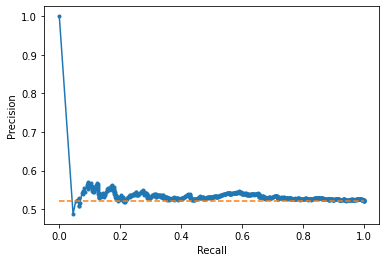

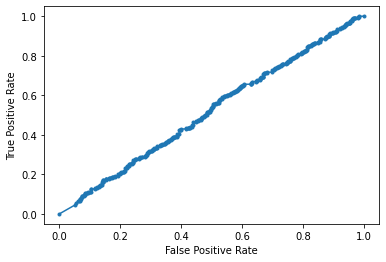

Accuracy: 51.35% Precision: 53.35% Recall: 52.26%
F1: 52.80% MCC: 0.0263
AUPRC: 54.26% AUROC: 51.97%
 accuracy [51.35453474676089]
 precision [53.34872979214781]
 recall [52.26244343891403]
 F1 [52.800000000000004]
 MCC [0.026292843213605695]
 AUPRC [54.25592958127883]
 AUROC [51.970049028872566]
2023-03-21 15:27:37.997034

Training # 1 4
2023-03-21 15:27:37.997271
2023-03-21 15:27:37.997341
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 15:27:39.250851


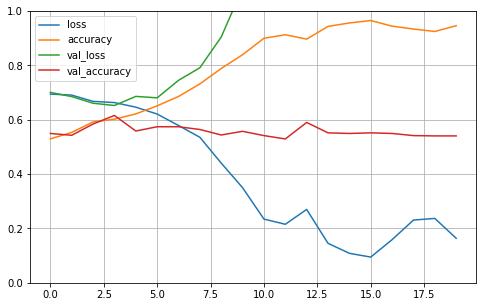


2023-03-21 15:30:02.725907

Testing # 1 4
2023-03-21 15:30:02.726027
2023-03-21 15:30:02.726071
PREDICT
2023-03-21 15:30:02.991162
Test 1:0 459:431 51.57%
Predict 1:0 480:410 53.93%
Test sizes (890, 4997) (890,)
Range of scores: 2.3155033e-21 to 1.0
Score threshold 0.5
Confusion matrix
 [[216 215]
 [194 265]]
Normalized matrix
 [[0.24269663 0.24157303]
 [0.21797753 0.29775281]]


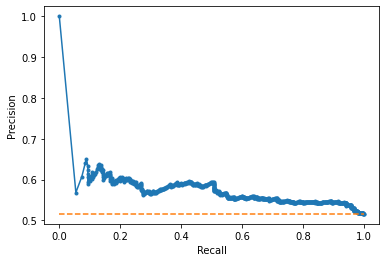

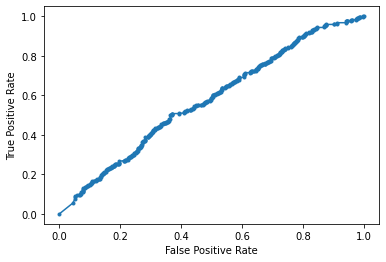

Accuracy: 54.04% Precision: 55.21% Recall: 57.73%
F1: 56.44% MCC: 0.0787
AUPRC: 58.12% AUROC: 57.51%
 accuracy [54.044943820224724]
 precision [55.208333333333336]
 recall [57.73420479302832]
 F1 [56.443024494142705]
 MCC [0.07870710361094606]
 AUPRC [58.12101456858012]
 AUROC [57.51305420337766]
2023-03-21 15:30:04.503493

Training # 1 5
2023-03-21 15:30:04.504379
2023-03-21 15:30:04.504432
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 15:30:05.765267


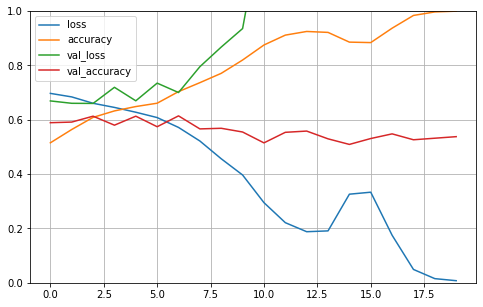


2023-03-21 15:32:29.191088

Testing # 1 5
2023-03-21 15:32:29.191193
2023-03-21 15:32:29.191235
PREDICT
2023-03-21 15:32:29.426304
Test 1:0 457:419 52.17%
Predict 1:0 458:418 52.28%
Test sizes (876, 4997) (876,)
Range of scores: 2.2476944e-17 to 1.0
Score threshold 0.5
Confusion matrix
 [[216 203]
 [202 255]]
Normalized matrix
 [[0.24657534 0.23173516]
 [0.23059361 0.29109589]]


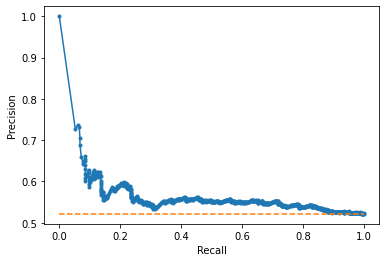

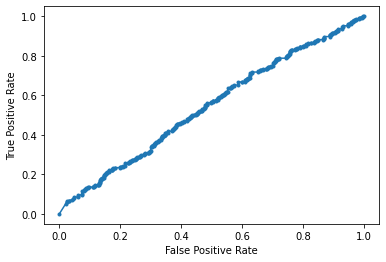

Accuracy: 53.77% Precision: 55.68% Recall: 55.80%
F1: 55.74% MCC: 0.0735
AUPRC: 57.32% AUROC: 54.38%
 accuracy [53.76712328767124]
 precision [55.67685589519651]
 recall [55.798687089715536]
 F1 [55.73770491803278]
 MCC [0.07350748353077009]
 AUPRC [57.323669941445196]
 AUROC [54.37662873466574]
2023-03-21 15:32:30.794653

Training # 2 1
2023-03-21 15:32:30.795525
2023-03-21 15:32:30.795575
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 15:32:32.051143


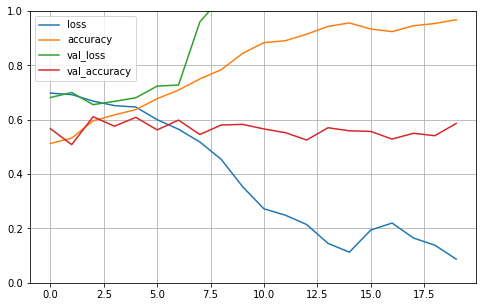


2023-03-21 15:34:55.479540

Testing # 2 1
2023-03-21 15:34:55.479634
2023-03-21 15:34:55.479671
PREDICT
2023-03-21 15:34:55.708243
Test 1:0 472:415 53.21%
Predict 1:0 399:488 44.98%
Test sizes (887, 4997) (887,)
Range of scores: 1.2076916e-27 to 1.0
Score threshold 0.5
Confusion matrix
 [[268 147]
 [220 252]]
Normalized matrix
 [[0.30214205 0.16572717]
 [0.24802706 0.28410372]]


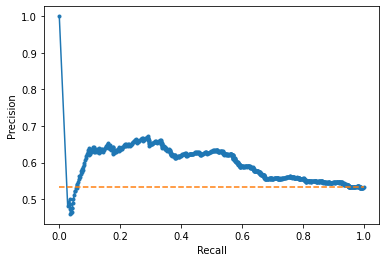

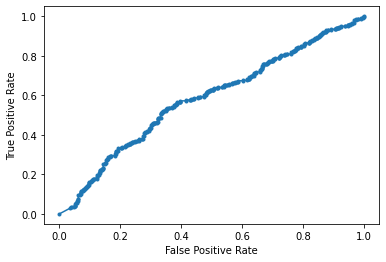

Accuracy: 58.62% Precision: 63.16% Recall: 53.39%
F1: 57.86% MCC: 0.1802
AUPRC: 59.93% AUROC: 58.33%
 accuracy [58.62457722660653]
 precision [63.1578947368421]
 recall [53.38983050847458]
 F1 [57.86452353616532]
 MCC [0.18021955065101733]
 AUPRC [59.93337952666023]
 AUROC [58.328568511333465]
2023-03-21 15:34:57.729312

Training # 2 2
2023-03-21 15:34:57.729534
2023-03-21 15:34:57.729585
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 15:34:58.990312


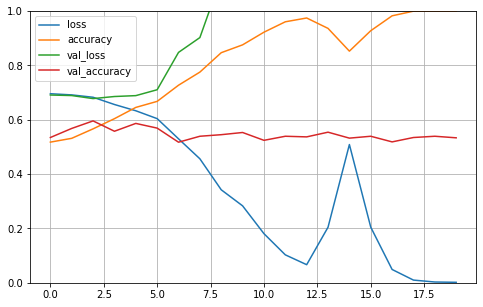


2023-03-21 15:37:22.642721

Testing # 2 2
2023-03-21 15:37:22.642815
2023-03-21 15:37:22.642852
PREDICT
2023-03-21 15:37:22.872797
Test 1:0 452:416 52.07%
Predict 1:0 455:413 52.42%
Test sizes (868, 4997) (868,)
Range of scores: 1.4619347e-15 to 1.0
Score threshold 0.5
Confusion matrix
 [[212 204]
 [201 251]]
Normalized matrix
 [[0.24423963 0.23502304]
 [0.23156682 0.28917051]]


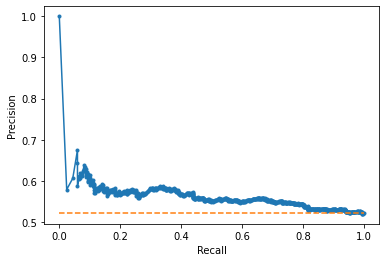

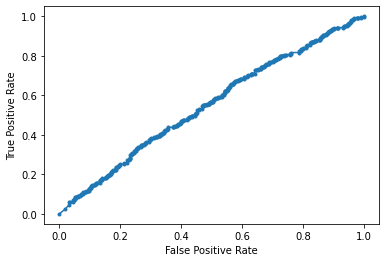

Accuracy: 53.34% Precision: 55.16% Recall: 55.53%
F1: 55.35% MCC: 0.0649
AUPRC: 56.59% AUROC: 55.12%
 accuracy [53.3410138248848]
 precision [55.16483516483517]
 recall [55.530973451327434]
 F1 [55.34729878721058]
 MCC [0.06494532788503754]
 AUPRC [56.58707770477462]
 AUROC [55.1198732130701]
2023-03-21 15:37:24.274477

Training # 2 3
2023-03-21 15:37:24.275038
2023-03-21 15:37:24.275118
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 15:37:25.527034


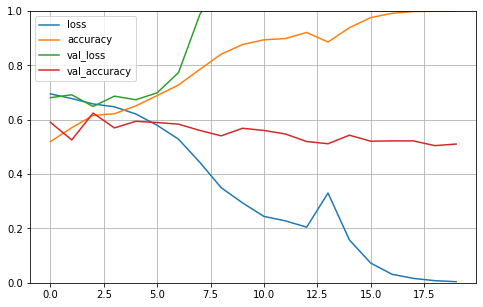


2023-03-21 15:39:49.458843

Testing # 2 3
2023-03-21 15:39:49.458949
2023-03-21 15:39:49.458993
PREDICT
2023-03-21 15:39:49.692350
Test 1:0 453:407 52.67%
Predict 1:0 470:390 54.65%
Test sizes (860, 4997) (860,)
Range of scores: 4.9653957e-23 to 1.0
Score threshold 0.5
Confusion matrix
 [[188 219]
 [202 251]]
Normalized matrix
 [[0.21860465 0.25465116]
 [0.23488372 0.29186047]]


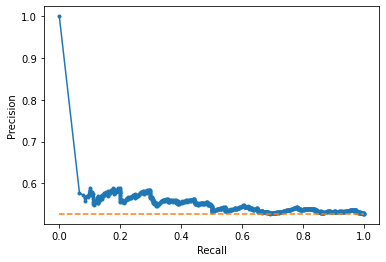

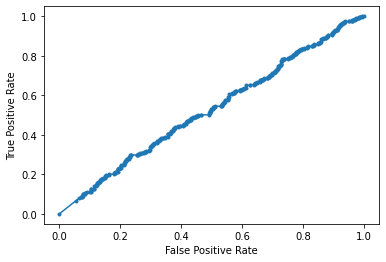

Accuracy: 51.05% Precision: 53.40% Recall: 55.41%
F1: 54.39% MCC: 0.0160
AUPRC: 56.46% AUROC: 52.83%
 accuracy [51.04651162790697]
 precision [53.404255319148945]
 recall [55.40838852097131]
 F1 [54.3878656554713]
 MCC [0.016047023103236642]
 AUPRC [56.455773497716535]
 AUROC [52.829078325767064]
2023-03-21 15:39:51.261740

Training # 2 4
2023-03-21 15:39:51.262653
2023-03-21 15:39:51.262705
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 15:39:52.663008


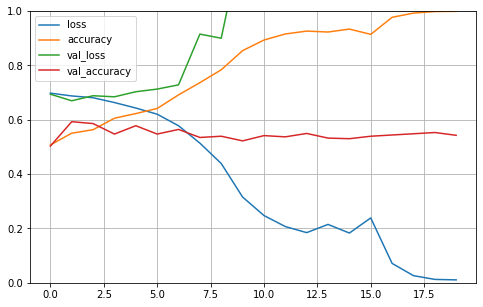


2023-03-21 15:42:16.647445

Testing # 2 4
2023-03-21 15:42:16.647546
2023-03-21 15:42:16.647582
PREDICT
2023-03-21 15:42:16.899823
Test 1:0 432:447 49.15%
Predict 1:0 486:393 55.29%
Test sizes (879, 4997) (879,)
Range of scores: 1.5349702e-18 to 1.0
Score threshold 0.5
Confusion matrix
 [[219 228]
 [174 258]]
Normalized matrix
 [[0.24914676 0.25938567]
 [0.19795222 0.29351536]]


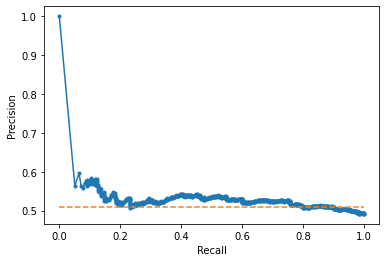

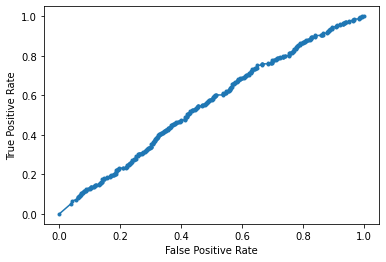

Accuracy: 54.27% Precision: 53.09% Recall: 59.72%
F1: 56.21% MCC: 0.0876
AUPRC: 53.98% AUROC: 55.28%
 accuracy [54.26621160409556]
 precision [53.086419753086425]
 recall [59.72222222222222]
 F1 [56.209150326797385]
 MCC [0.08763428974995906]
 AUPRC [53.979584742530776]
 AUROC [55.27979741486453]
2023-03-21 15:42:18.634188

Training # 2 5
2023-03-21 15:42:18.636553
2023-03-21 15:42:18.636632
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 15:42:21.304268


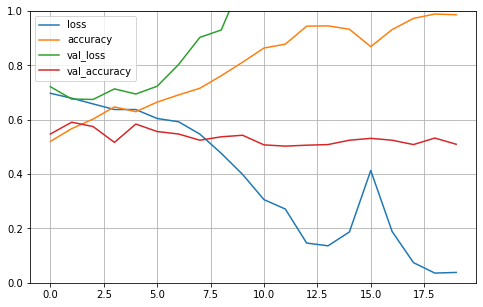


2023-03-21 15:44:45.125128

Testing # 2 5
2023-03-21 15:44:45.125244
2023-03-21 15:44:45.125284
PREDICT
2023-03-21 15:44:45.582366
Test 1:0 449:426 51.31%
Predict 1:0 436:439 49.83%
Test sizes (875, 4997) (875,)
Range of scores: 8.2177004e-27 to 1.0
Score threshold 0.5
Confusion matrix
 [[218 208]
 [221 228]]
Normalized matrix
 [[0.24914286 0.23771429]
 [0.25257143 0.26057143]]


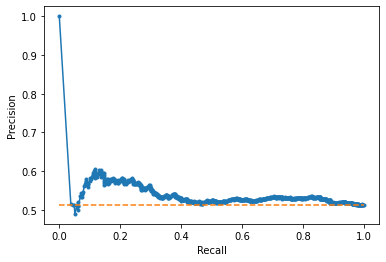

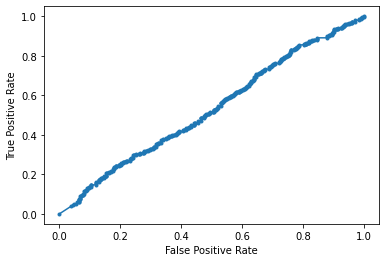

Accuracy: 50.97% Precision: 52.29% Recall: 50.78%
F1: 51.53% MCC: 0.0195
AUPRC: 54.52% AUROC: 53.05%
 accuracy [50.97142857142857]
 precision [52.293577981651374]
 recall [50.779510022271715]
 F1 [51.52542372881355]
 MCC [0.01952555524788005]
 AUPRC [54.52375307531281]
 AUROC [53.05425724353545]
2023-03-21 15:44:46.992415


In [22]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [23]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 53.08% std 2.42
 precision mean 54.77% std 3.15
 recall mean 53.95% std 4.42
 F1 mean 54.24% std 2.84
 MCC mean 0.06% std 0.05
 AUPRC mean 55.92% std 2.13
 AUROC mean 54.50% std 2.08
 accuracy [[50.3448275862069], [53.05429864253394], [51.35453474676089], [54.044943820224724], [53.76712328767124], [58.62457722660653], [53.3410138248848], [51.04651162790697], [54.26621160409556], [50.97142857142857]]
 precision [[53.475935828877006], [52.92841648590022], [53.34872979214781], [55.208333333333336], [55.67685589519651], [63.1578947368421], [55.16483516483517], [53.404255319148945], [53.086419753086425], [52.293577981651374]]
 recall [[43.66812227074236], [55.203619909502265], [52.26244343891403], [57.73420479302832], [55.798687089715536], [53.38983050847458], [55.530973451327434], [55.40838852097131], [59.72222222222222], [50.779510022271715]]
 F1 [[48.07692307692308], [54.042081949058684], [52.800000000000004], [56.443024494142705], [55.73770491803278], [57.86452353616532],